# Fitting LoS distributions for HEP

* Primary Hip
* Revision Hip
* Primary Knee
* Revision Knee
* Unicompartmental knee
* Delayed discharge

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

In [8]:
HipKnee_1320_mffd = pd.read_csv("HipKnee_with_los_delay.csv", usecols = ['admission_date',
                                                                         'discharge_date',
                                                                         'spell_los',
                                                                         'mffd',
                                                                         'cancelled_ops_non_clinical',
                                                                         'hip_prim_proc',
                                                                         'knee_prim_proc',
                                                                         'surgery_site'])

## Calculate proportions of surgical types within Hips and Knees

In [9]:
length_hip = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['surgery_site'] == "Site: hip"] 
length_knee = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['surgery_site'] == "Site: knee"]

primary_hip_n = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['hip_prim_proc'] == "Primary THR"]
revision_hip_n = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['hip_prim_proc'] == "Revision of hip"]
hip_resurfacing_n =  HipKnee_1320_mffd.loc[HipKnee_1320_mffd['hip_prim_proc'] == "Hip resurfacing"]

primary_knee_n = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['knee_prim_proc'] == "Primary TKR"]
revision_knee_n = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['knee_prim_proc'] == "Revision of knee"]
unicompart_knee_n = HipKnee_1320_mffd.loc[HipKnee_1320_mffd['knee_prim_proc'] == "Primary UKR"]


In [10]:
prop_prim_hip = primary_hip_n.shape[0] / length_hip.shape[0]
prop_rev_hip = revision_hip_n.shape[0] / length_hip.shape[0]
prop_hip_resurfacing = hip_resurfacing_n.shape[0] / length_hip.shape[0]
tot_hips = prop_prim_hip + prop_rev_hip + prop_hip_resurfacing

prop_prim_knee = primary_knee_n.shape[0] / length_knee.shape[0]
prop_rev_knee = revision_knee_n.shape[0] / length_knee.shape[0]
prop_uncompart_knee = unicompart_knee_n.shape[0] / length_knee.shape[0]
tot_knees = prop_prim_knee + prop_rev_knee + prop_uncompart_knee

In [11]:
print(prop_prim_hip, prop_rev_hip, prop_prim_knee, prop_rev_knee, prop_uncompart_knee)

0.8616121758737317 0.1358511837655017 0.6738875878220141 0.11475409836065574 0.1987704918032787


## Calculate proportions of surgical types within classes: Primary and Revision

In [12]:
prop_primary_hips = primary_hip_n.shape[0] / (primary_hip_n.shape[0] + primary_knee_n.shape[0] + unicompart_knee_n.shape[0])
prop_primary_knees = primary_knee_n.shape[0] / (primary_knee_n.shape[0] + primary_hip_n.shape[0] + unicompart_knee_n.shape[0])
prop_unicompart_knees = unicompart_knee_n.shape[0] / (primary_knee_n.shape[0] + primary_hip_n.shape[0] + unicompart_knee_n.shape[0])

prop_revision_hips = revision_hip_n.shape[0] / (revision_hip_n.shape[0] + revision_knee_n.shape[0])
prop_revision_knees = revision_knee_n.shape[0] / (revision_hip_n.shape[0] + revision_knee_n.shape[0])

In [13]:
print(prop_primary_hips, prop_primary_knees, prop_unicompart_knees, prop_revision_hips, prop_revision_knees)

0.5062934746604836 0.3812520702219278 0.1124544551175886 0.551487414187643 0.448512585812357


## Calculate proportion delayed

* Overall delay for all surgical types

In [14]:
delay_n = HipKnee_1320_mffd[HipKnee_1320_mffd['mffd'].isna()]
delay_prop = (HipKnee_1320_mffd.shape[0] - delay_n.shape[0]) / HipKnee_1320_mffd.shape[0]

In [15]:
delay_prop

0.07596209075244112

In [19]:
# dataframes for checking
primary_knee_del = primary_knee_n[primary_knee_n['mffd'].notna()]
uni_knee_del = unicompart_knee_n[unicompart_knee_n['mffd'].notna()]
revise_knee_del = revision_knee_n[revision_knee_n['mffd'].notna()]
primary_hip_del = primary_hip_n[primary_hip_n['mffd'].notna()]
revise_hip_del = revision_hip_n[revision_hip_n['mffd'].notna()]

# checking proportions
prop_primary_knee_del = len(primary_knee_del) / (len(primary_knee) + len(primary_knee_del))
prop_revision_knee_del = len(revise_knee_del) / (len(revise_knee) + len(revise_knee_del))
prop_unicom_knee_del = len(uni_knee_del) / (len(uni_knee) + len(uni_knee_del))
prop_primary_hip_del = len(primary_hip_del) / (len(primary_hip) + len(primary_hip_del))
prop_revison_hip_del = len(revise_hip_del) / (len(revise_hip) + len(revise_hip_del))

In [20]:
print(prop_primary_hip_del, prop_primary_knee_del, prop_revison_hip_del, prop_revision_knee_del, prop_unicom_knee_del)

0.0775269872423945 0.06602953953084274 0.15767634854771784 0.1326530612244898 0.016200294550810016


## Create vectors for fitting no delay LoS

In [21]:
primary_knee = primary_knee_n[primary_knee_n['mffd'].isna()]
uni_knee = unicompart_knee_n[unicompart_knee_n['mffd'].isna()]
revise_knee = revision_knee_n[revision_knee_n['mffd'].isna()]
primary_hip = primary_hip_n[primary_hip_n['mffd'].isna()]
revise_hip = revision_hip_n[revision_hip_n['mffd'].isna()]

# vectors
primary_knee_v = primary_knee['spell_los'].tolist()
uni_knee_v = uni_knee['spell_los'].tolist()
revise_knee_v = revise_knee['spell_los'].tolist()
primary_hip_v = primary_hip['spell_los'].tolist()
revise_hip_v = revise_hip['spell_los'].tolist()

## Los vector for delayed discharge (all surgical types)

In [22]:
delayed_los = HipKnee_1320_mffd[HipKnee_1320_mffd['mffd'].notna()]
delayed_los_v = delayed_los['spell_los'].tolist()

## Plot LoS distributions
* Summarise

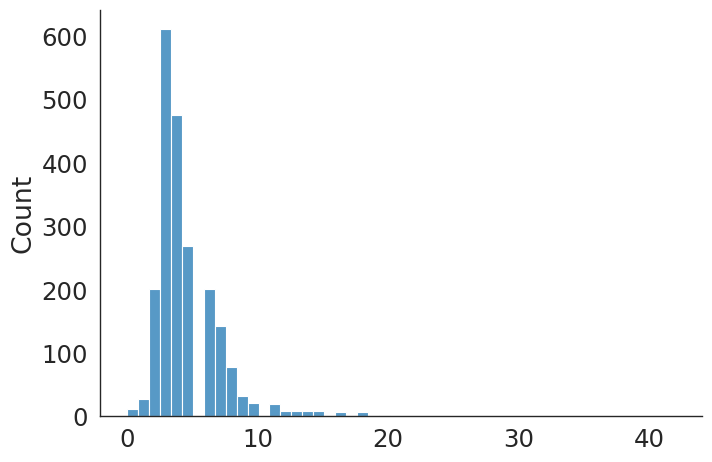

In [23]:
#plt.hist(primary_knee_v, bins=50);

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(data=primary_knee_v, kind="hist", bins = 50, aspect = 1.5)

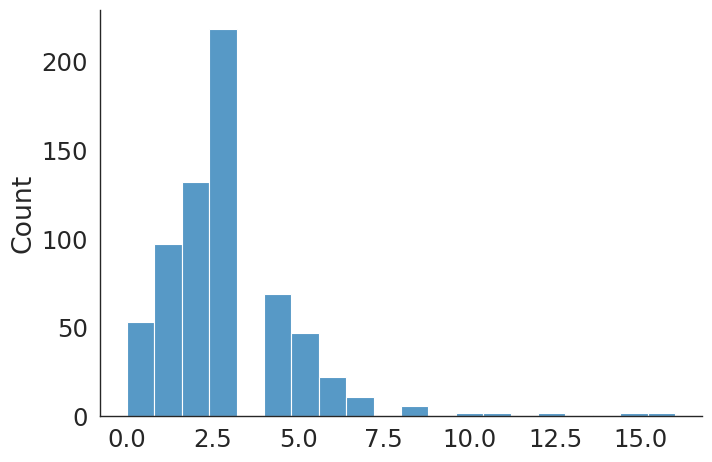

In [24]:
#plt.hist(uni_knee_v, bins=20);

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(data=uni_knee_v, kind="hist", bins = 20, aspect = 1.5)

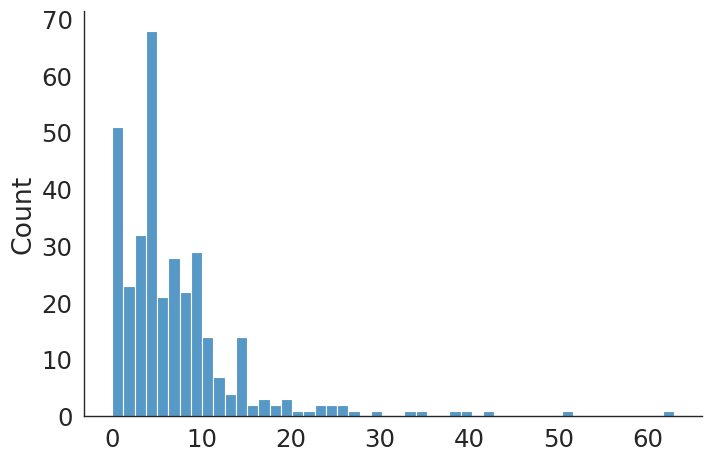

In [25]:
#plt.hist(revise_knee_v, bins=50);

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(data=revise_knee_v, kind="hist", bins = 50, aspect = 1.5)

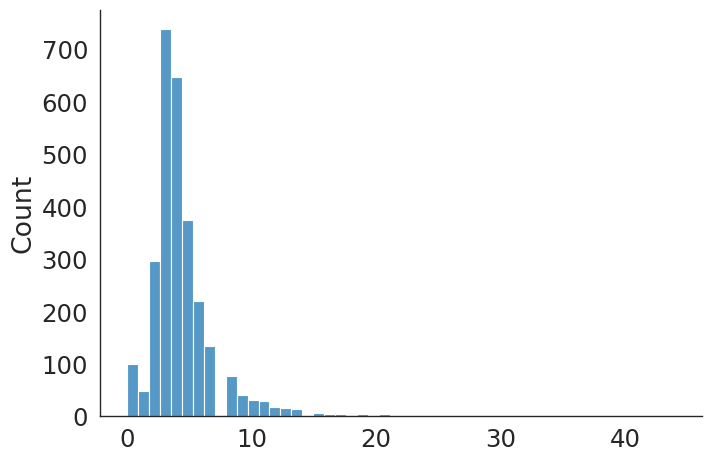

In [26]:
#plt.hist(primary_hip_v, bins=50);
sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(data=primary_hip_v, kind="hist", bins = 50, aspect = 1.5)

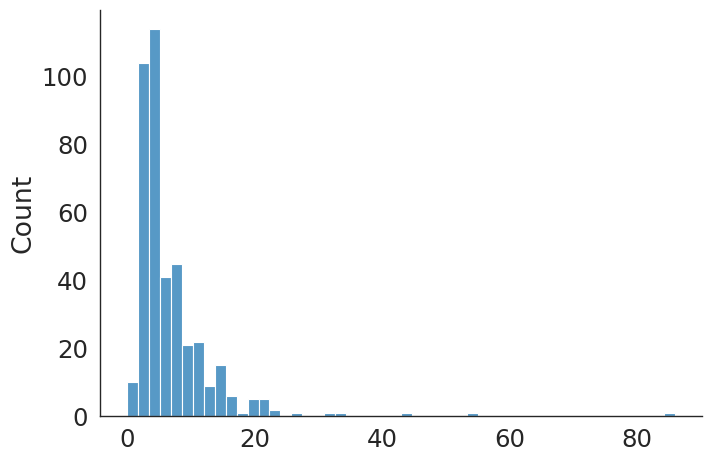

In [27]:
#plt.hist(revise_hip_v, bins=50);

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(revise_hip_v, kind="hist", bins = 50, aspect = 1.5)

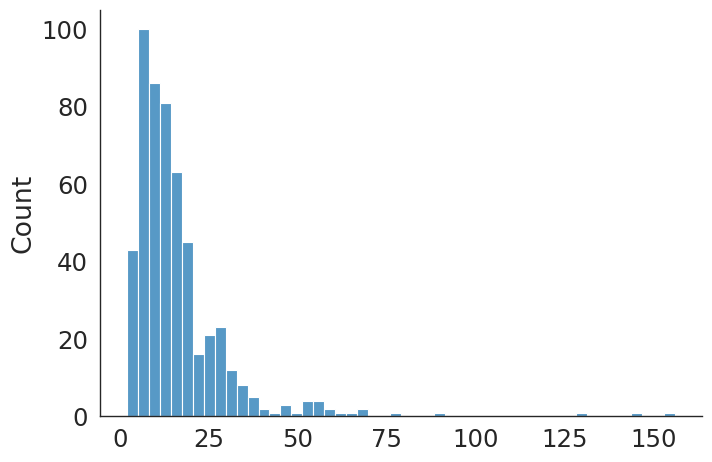

In [28]:
#plt.hist(delayed_los_v, bins=50);

sns.set_style('white')
sns.set_context("paper", font_scale = 2)

sns.displot(delayed_los_v, kind="hist", bins = 50, aspect = 1.5)

In [29]:
delay_los_pdv = pd.Series(delayed_los_v)
print("delay_los", delay_los_pdv.describe())

primary_knee_pdv = pd.Series(primary_knee_v)
print("primary_knee", primary_knee_pdv.describe())

uni_knee_pdv = pd.Series(uni_knee_v)
print("uni_knee", uni_knee_pdv.describe())

revise_knee_pdv = pd.Series(revise_knee_v)
print("revise_knee", revise_knee_pdv.describe())

primary_hip_pdv = pd.Series(primary_hip_v)
print("primary_hip", primary_hip_pdv.describe())

revise_hip_pdv = pd.Series(revise_hip_v)
print("revise_hip", revise_hip_pdv.describe())

delay_los count    529.000000
mean      16.521739
std       15.153132
min        2.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      156.000000
dtype: float64
primary_knee count    2150.000000
mean        4.651163
std         2.828129
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        42.000000
dtype: float64
uni_knee count    668.000000
mean       2.914671
std        2.136334
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       16.000000
dtype: float64
revise_knee count    340.000000
mean       7.194118
std        7.598554
min        0.000000
25%        3.000000
50%        5.000000
75%        9.000000
max       63.000000
dtype: float64
primary_hip count    2820.000000
mean        4.433333
std         2.949526
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        44.000000
dtype: float64
revise_hip count    406.000000
mean       6.908867
st

# Convert to NumPy arrays for use in fitter

In [30]:
delay_los_npv = np.asarray(delayed_los_v)
primary_knee_npv = np.asarray(primary_knee_v)
uni_knee_npv = np.asarray(uni_knee_v)
revise_knee_npv = np.asarray(revise_knee_v)
primary_hip_npv = np.asarray(primary_hip_v)
revise_hip_npv = np.asarray(revise_hip_v)

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 28.96it/s]

         sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm         0.004644  1608.122559 -6140.474568     inf      0.051474   
beta            0.005357  1924.655190 -6058.553177     inf      0.087312   
expon           0.009436  1599.608397 -5771.632045     inf      0.162747   
gamma           0.035865  6380.344444 -5059.053541     inf      0.921926   

            ks_pvalue  
lognorm  1.170505e-01  
beta     5.866521e-04  
expon    1.037166e-12  
gamma    0.000000e+00  


{'lognorm': {'s': 0.6977106156387711,
  'loc': 0.46203959259225885,
  'scale': 12.381893465319441}}

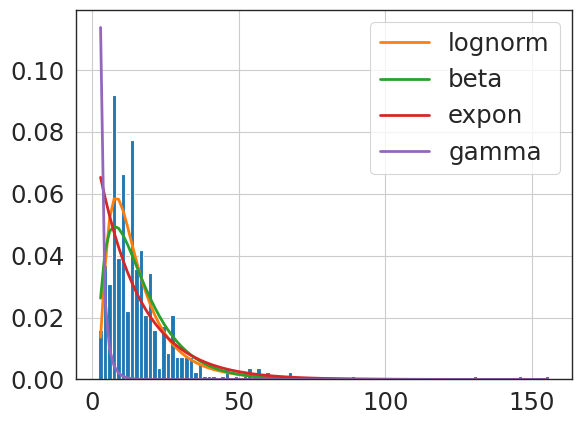

In [31]:
f = Fitter(delay_los_npv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 22.47it/s]


         sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm         0.578484  1860.575987 -17651.201383     inf      0.151704   
expon           0.792283  1214.423450 -16982.682686     inf      0.363244   
beta            0.904699  1153.425425 -16682.064683     inf      0.427036   
gamma           1.696721  2924.646338 -15337.709648     inf      0.872199   

             ks_pvalue  
lognorm   1.150099e-43  
expon    1.064843e-254  
beta      0.000000e+00  
gamma     0.000000e+00  


{'lognorm': {'s': 0.4054742453283533,
  'loc': -1.0156970361318063,
  'scale': 5.187968679570998}}

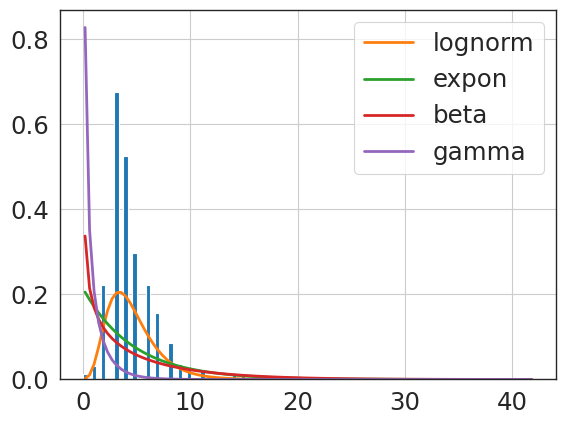

In [32]:
f = Fitter(primary_knee_npv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 36.73it/s]

         sumsquare_error         aic          bic  kl_div  ks_statistic  \
lognorm         6.349747  924.541981 -3090.610424     inf      0.171962   
gamma           6.363627  945.514562 -3089.151847     inf      0.167334   
beta            6.373490  921.072492 -3081.613030     inf      0.168304   
expon           6.603280  766.898464 -3070.961471     inf      0.271955   

            ks_pvalue  
lognorm  9.648984e-18  
gamma    8.102790e-17  
beta     5.212017e-17  
expon    3.872916e-44  


{'lognorm': {'s': 0.3803355622865142,
  'loc': -2.1623715729774657,
  'scale': 4.71533144760631}}

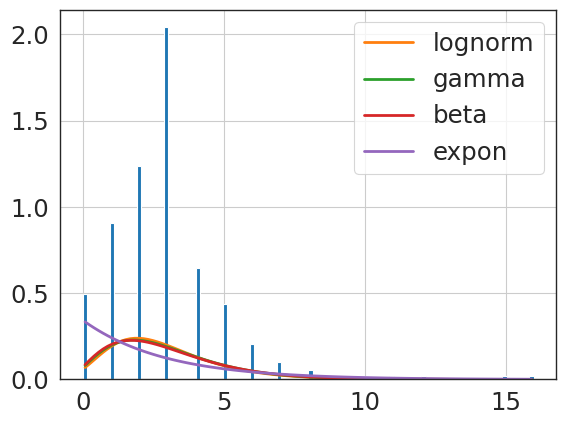

In [33]:
f = Fitter(uni_knee_pdv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 27.19it/s]

         sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon           0.068790  1274.368194 -2880.262979     inf      0.123337   
beta            0.100426  1301.742494 -2739.959169     inf      0.310421   
lognorm         0.118113  1229.635547 -2690.633827     inf      0.366558   
gamma           0.398495  4032.310584 -2277.175334     inf      0.699071   

             ks_pvalue  
expon     5.759763e-05  
beta      1.342060e-29  
lognorm   1.816040e-41  
gamma    5.534748e-167  


{'expon': {'loc': 0.0, 'scale': 7.194117647058824}}

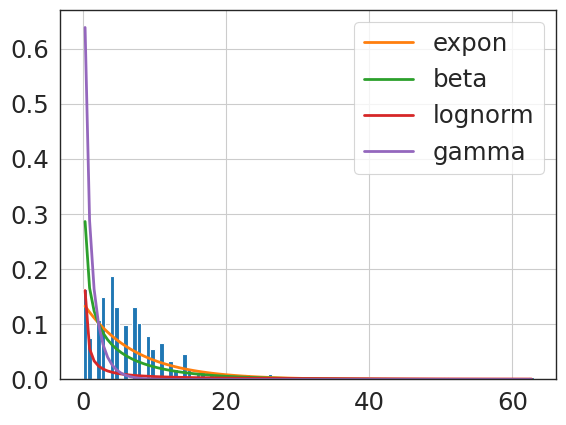

In [34]:
f = Fitter(revise_knee_npv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 22.51it/s]


         sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm         0.509158  1963.042781 -24283.125652     inf      0.166587   
beta            0.516464  2432.283680 -24235.005142     inf      0.168023   
expon           0.654193  1294.311552 -23584.255723     inf      0.334257   
gamma           0.686329  1119.561080 -23441.078834     inf      0.325523   

             ks_pvalue  
lognorm   7.205752e-69  
beta      4.630348e-70  
expon    2.091397e-281  
gamma    1.536661e-266  


{'lognorm': {'s': 0.3615166592899655,
  'loc': -2.4363376840086204,
  'scale': 6.4116655364890836}}

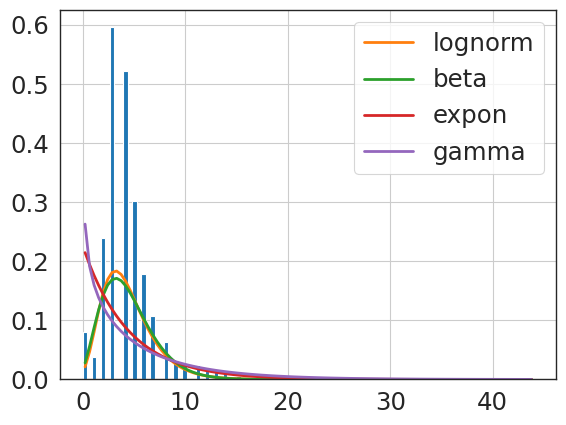

In [35]:
f = Fitter(primary_hip_npv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 30.62it/s]

         sumsquare_error          aic          bic  kl_div  ks_statistic  \
lognorm         0.022496  1733.019612 -3961.087365     inf      0.107411   
beta            0.033304  2128.183021 -3795.802654     inf      0.142546   
expon           0.059486  1635.338315 -3572.307506     inf      0.241396   
gamma           0.138877  3996.315953 -3222.070957     inf      0.938027   

            ks_pvalue  
lognorm  1.559684e-04  
beta     1.162057e-07  
expon    2.614308e-21  
gamma    0.000000e+00  


{'lognorm': {'s': 0.6152292643165856,
  'loc': -0.934387442319201,
  'scale': 6.350152207311825}}

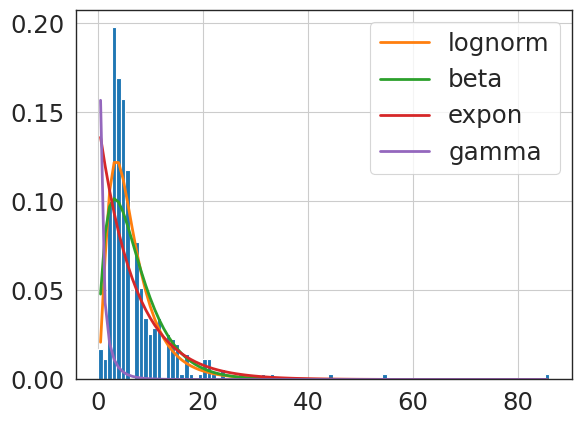

In [36]:
f = Fitter(revise_hip_npv,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

In [37]:
f.get_best(method = 'sumsquare_error')

{'lognorm': {'s': 0.6152292643165856,
  'loc': -0.934387442319201,
  'scale': 6.350152207311825}}

## Clip arrays

In [40]:
delay_los_npv_clip = np.asarray(delayed_los_v) # leave as is
primary_knee_npv_clip = np.clip(np.asarray(primary_knee_v), 0, 30)
uni_knee_npv_clip = np.clip(np.asarray(uni_knee_v), 0, 30)
revise_knee_npv_clip = np.clip(np.asarray(revise_knee_v), 0, 30)
primary_hip_npv_clip = np.clip(np.asarray(primary_hip_v), 0, 30)
revise_hip_npv_clip = np.clip(np.asarray(revise_hip_v), 0, 30)

## Fit clipped data

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 24.66it/s]

         sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm         1.352282  1383.035323 -15825.554283     inf      0.151034   
gamma           1.369003  1633.491636 -15799.132769     inf      0.167515   
beta            1.371934  1592.110062 -15786.860642     inf      0.166926   
expon           1.651798   957.270922 -15403.074367     inf      0.363888   

             ks_pvalue  
lognorm   2.775736e-43  
gamma     3.330412e-53  
beta      7.852058e-53  
expon    1.245667e-255  


{'lognorm': {'s': 0.40225541615533966,
  'loc': -1.0399482363715324,
  'scale': 5.212995574296882}}

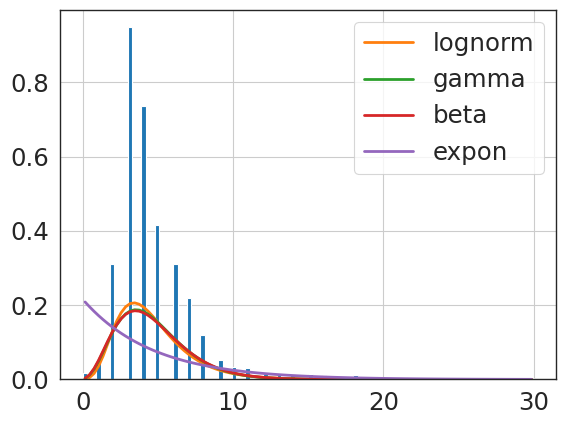

In [41]:
f = Fitter(primary_knee_npv_clip,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 38.02it/s]

         sumsquare_error         aic          bic  kl_div  ks_statistic  \
lognorm         6.349747  924.541981 -3090.610424     inf      0.171962   
gamma           6.363627  945.514562 -3089.151847     inf      0.167334   
beta            6.373490  921.072492 -3081.613030     inf      0.168304   
expon           6.603280  766.898464 -3070.961471     inf      0.271955   

            ks_pvalue  
lognorm  9.648984e-18  
gamma    8.102790e-17  
beta     5.212017e-17  
expon    3.872916e-44  


{'lognorm': {'s': 0.3803355622865142,
  'loc': -2.1623715729774657,
  'scale': 4.71533144760631}}

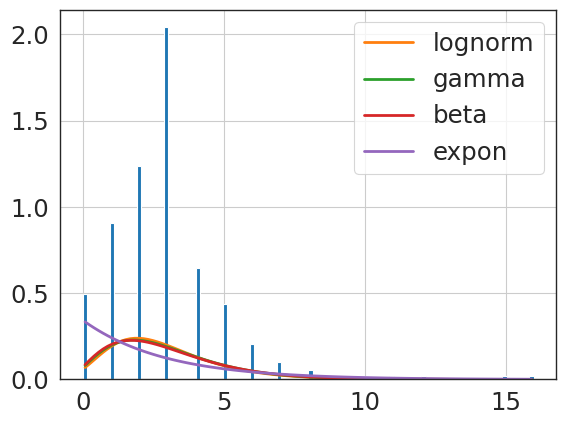

In [42]:
f = Fitter(uni_knee_npv_clip,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 20.71it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
expon           0.553174   824.389317 -2171.491717     inf      0.134110   
beta            0.567029   862.802255 -2151.423185     inf      0.246918   
lognorm         0.614330  1100.527541 -2130.010433     inf      0.399620   
gamma           0.635206   904.170953 -2118.648631     inf      0.369219   

            ks_pvalue  
expon    8.562804e-06  
beta     9.612934e-19  
lognorm  1.649474e-49  
gamma    4.379593e-42  


{'expon': {'loc': 0.0, 'scale': 6.920588235294118}}

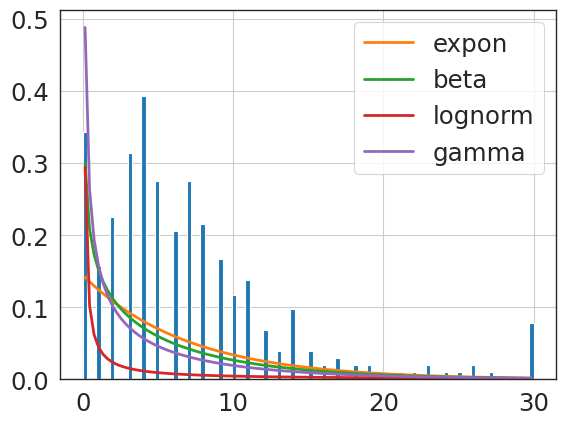

In [43]:
f = Fitter(revise_knee_npv_clip,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 29.04it/s]

         sumsquare_error          aic           bic  kl_div  ks_statistic  \
lognorm         1.309768  1377.265202 -21618.657207     inf      0.165827   
gamma           1.321269  1546.157021 -21594.003778     inf      0.166356   
beta            1.324767  1505.611887 -21578.602914     inf      0.169617   
expon           1.537796   979.324423 -21173.990919     inf      0.334836   

             ks_pvalue  
lognorm   3.051803e-68  
gamma     1.117626e-68  
beta      2.135810e-71  
expon    2.091822e-282  


{'lognorm': {'s': 0.35741083072060453,
  'loc': -2.489064861474697,
  'scale': 6.466619066862258}}

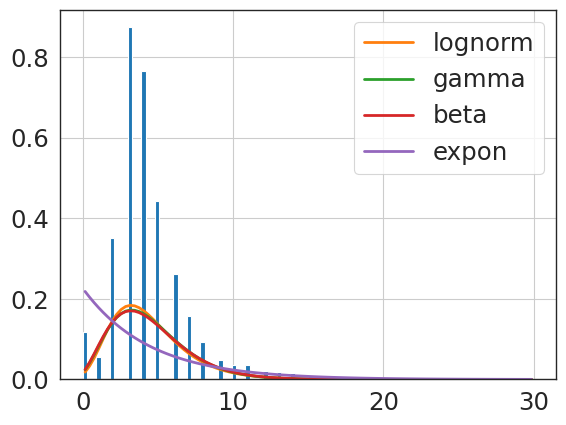

In [44]:
f = Fitter(primary_hip_npv_clip,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

Fitting 4 distributions: 100%|████████████████████| 4/4 [00:00<00:00, 37.23it/s]


         sumsquare_error         aic          bic  kl_div  ks_statistic  \
lognorm         0.780455  903.666307 -2521.198708     inf      0.106709   
beta            0.796737  919.212449 -2506.809528     inf      0.132526   
gamma           0.796812  916.728918 -2512.777811     inf      0.132578   
expon           0.885004  833.485595 -2476.164953     inf      0.251605   

            ks_pvalue  
lognorm  1.764127e-04  
beta     1.116592e-06  
gamma    1.104079e-06  
expon    3.889626e-23  


{'lognorm': {'s': 0.5796389432896831,
  'loc': -1.102767801493329,
  'scale': 6.517280834355917}}

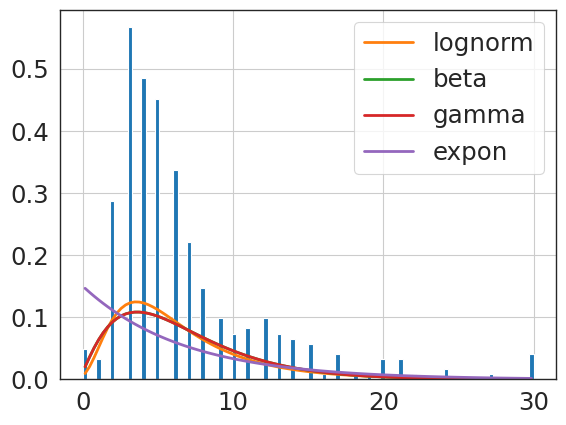

In [45]:
f = Fitter(revise_hip_npv_clip,
           distributions=['gamma',
                          'lognorm',
                          'beta',
                          'expon'
                          ]);
f.fit()
print(f.summary())
f.get_best(method = 'sumsquare_error')

## Summarise clipped data

In [46]:
delay_los_pdv = pd.Series(delay_los_npv_clip)
print("delay_los", delay_los_pdv.describe())

primary_knee_pdv = pd.Series(primary_knee_npv_clip)
print("primary_knee", primary_knee_pdv.describe())

uni_knee_pdv = pd.Series(uni_knee_npv_clip)
print("uni_knee", uni_knee_pdv.describe())

revise_knee_pdv = pd.Series(revise_knee_npv_clip)
print("revise_knee", revise_knee_pdv.describe())

primary_hip_pdv = pd.Series(primary_hip_npv_clip)
print("primary_hip", primary_hip_pdv.describe())

revise_hip_pdv = pd.Series(revise_hip_npv_clip)
print("revise_hip", revise_hip_pdv.describe())


delay_los count    529.000000
mean      16.521739
std       15.153132
min        2.000000
25%        8.000000
50%       13.000000
75%       19.000000
max      156.000000
dtype: float64
primary_knee count    2150.000000
mean        4.642326
std         2.731335
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        30.000000
dtype: float64
uni_knee count    668.000000
mean       2.914671
std        2.136334
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       16.000000
dtype: float64
revise_knee count    340.000000
mean       6.920588
std        6.291085
min        0.000000
25%        3.000000
50%        5.000000
75%        9.000000
max       30.000000
dtype: float64
primary_hip count    2820.000000
mean        4.425887
std         2.869115
min         0.000000
25%         3.000000
50%         4.000000
75%         5.000000
max        30.000000
dtype: float64
revise_hip count    406.000000
mean       6.665025
st